In [1]:
# !pip install tensorflow


In [4]:
# !pip install earthpy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import keras
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import seaborn as sns
from osgeo import gdal
from keras import layers, Sequential, Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, Callback

In [2]:
%load_ext tensorboard

In [3]:
model_dir_name = r'C:\Users\kenny\My Files\NUS\ISY5002 Pattern Recognition Systems\04. PRS-PM Practice Module\Code\models'
log_dir_name = r'C:\Users\kenny\My Files\NUS\ISY5002 Pattern Recognition Systems\04. PRS-PM Practice Module\Code\logs'
output_dir_name = r'C:\Users\kenny\My Files\NUS\ISY5002 Pattern Recognition Systems\04. PRS-PM Practice Module\Code\output'

In [4]:
base_dir_name = r'C:\Users\kenny\My Files\NUS\ISY5002 Pattern Recognition Systems\04. PRS-PM Practice Module\DFC_Public_Dataset\DFC_Public_Dataset'
all_files = os.listdir(base_dir_name)
season_dirs = [file_name for file_name in all_files if os.path.isdir(os.path.join(base_dir_name, file_name)) and file_name.startswith("ROIs0000")]

print(season_dirs)

['ROIs0000_autumn', 'ROIs0000_spring', 'ROIs0000_summer', 'ROIs0000_winter']


In [5]:
dfc_labels = []
s2_images = []

for season_dir in season_dirs:
    season_dir_path = '{}/{}'.format(base_dir_name, season_dir)
    sub_dirs = os.listdir(season_dir_path)
    sub_dirs = [sub_dir for sub_dir in sub_dirs if sub_dir.startswith("dfc") or sub_dir.startswith("s2")]
    
    for sub_dir in sub_dirs:
        sub_dir_path = "{}/{}".format(season_dir_path, sub_dir)
        files = os.listdir(sub_dir_path)
        files = ['{}/{}'.format(sub_dir_path, filename) for filename in files]
        
        if sub_dir.startswith("dfc"):
            dfc_labels.extend(files)
        else:
            s2_images.extend(files)

s2_images.sort()
dfc_labels.sort()

print(s2_images)
print(dfc_labels)


['C:\\Users\\kenny\\My Files\\NUS\\ISY5002 Pattern Recognition Systems\\04. PRS-PM Practice Module\\DFC_Public_Dataset\\DFC_Public_Dataset/ROIs0000_autumn/s2_BandarAnzali/ROIs0000_autumn_s2_BandarAnzali_p100.tif', 'C:\\Users\\kenny\\My Files\\NUS\\ISY5002 Pattern Recognition Systems\\04. PRS-PM Practice Module\\DFC_Public_Dataset\\DFC_Public_Dataset/ROIs0000_autumn/s2_BandarAnzali/ROIs0000_autumn_s2_BandarAnzali_p101.tif', 'C:\\Users\\kenny\\My Files\\NUS\\ISY5002 Pattern Recognition Systems\\04. PRS-PM Practice Module\\DFC_Public_Dataset\\DFC_Public_Dataset/ROIs0000_autumn/s2_BandarAnzali/ROIs0000_autumn_s2_BandarAnzali_p102.tif', 'C:\\Users\\kenny\\My Files\\NUS\\ISY5002 Pattern Recognition Systems\\04. PRS-PM Practice Module\\DFC_Public_Dataset\\DFC_Public_Dataset/ROIs0000_autumn/s2_BandarAnzali/ROIs0000_autumn_s2_BandarAnzali_p103.tif', 'C:\\Users\\kenny\\My Files\\NUS\\ISY5002 Pattern Recognition Systems\\04. PRS-PM Practice Module\\DFC_Public_Dataset\\DFC_Public_Dataset/ROIs0000_

In [6]:
def pre_process_label(label):
    label[(label==4) | (label==6)] = 0 # shrubland, savanna, grassland, croplands
    label[label==5] = 1 # wetlands
    label[label==7] = 2 # urban
    label[label==9] = 3 # urban
    label[label==10] = 4
    return label

In [7]:
X_train, X_test, y_train, y_test = train_test_split(s2_images, dfc_labels, test_size=0.2, random_state=42)

In [8]:
INPUT_SHAPE = (256, 256, 14)
NUM_CLASSES = 6
MAX_VAL = 4096.0

# Augmentation Config
ROTATION_FACTOR = (-0.5, 0.5)
RAND_SEED = 42

# Training Config
BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 0.01
# LEARNING_RATE = 1e-4
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
def compute_ndvi(image_array):
    # Assuming Red band is the first channel (0th index) and NIR is the second channel (1st index)
    red = image_array[:, :, 3]
    nir = image_array[:, :, 7]

    # Compute NDVI
    ndvi = (nir - red) / (nir + red + 1e-10)  # Small value added to the denominator to prevent division by zero

    return ndvi


In [10]:
def load_and_preprocess_image(img_path):
    ds = gdal.Open(img_path)
    img = ds.ReadAsArray()
    img = np.moveaxis(img, 0, -1)

    ndvi = compute_ndvi(img)
    ndvi = (ndvi + 1.0) / 2.0  # Scale NDVI values to range [0, 1]
    ndvi = tf.expand_dims(ndvi, axis=-1)  # Add a channel dimension to NDVI
    ndvi = tf.clip_by_value(tf.cast(ndvi, tf.float32), 0., 1.)

    img = tf.clip_by_value(tf.cast(img, tf.float32) / MAX_VAL, 0., 1.)

    combined_img = tf.concat([img, ndvi], axis=-1)

    return combined_img




def load_and_preprocess_label(label_path):
    ds = gdal.Open(label_path)
    label = ds.ReadAsArray()
    label = np.moveaxis(label, 0, -1)
    label = pre_process_label(label)
    label = label[:,:,np.newaxis]
    return label

In [11]:
# Define a generator function that yields batches of data
def data_generator(img_path_arr,label_path_arr):

    for (img_path,label_path) in zip(img_path_arr,label_path_arr):
        img = load_and_preprocess_image(img_path)
        label = load_and_preprocess_label(label_path)

        yield img, label


# Create a dataset from the generator function
ori_train_ds = tf.data.Dataset.from_generator(
    data_generator,
    args=(X_train, y_train),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 14), dtype=tf.float32),  # Example: Data tensor specification
        tf.TensorSpec(shape=(256,256,1), dtype=tf.int8)   # Example: Label tensor specification
    )
)

# Create a dataset from the generator function
ori_eval_ds = tf.data.Dataset.from_generator(
    data_generator,
    args=(X_test, y_test),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 14), dtype=tf.float32),  # Example: Data tensor specification
        tf.TensorSpec(shape=(256,256,1), dtype=tf.int8)   # Example: Label tensor specification
    )
)

In [12]:
img_aug = Sequential([
        # layers.Resizing(height=self.img_size, width=self.img_size, interpolation='bicubic'),
        layers.RandomBrightness(factor=(-0.07, 0.1), value_range=[0.0, 1.], seed=RAND_SEED),
        layers.RandomFlip(mode='horizontal', seed=RAND_SEED),
        layers.RandomFlip(mode='vertical', seed=RAND_SEED),
        layers.RandomRotation(ROTATION_FACTOR, fill_mode='reflect', interpolation='bilinear', seed=RAND_SEED),
        layers.RandomTranslation(height_factor=0.15, width_factor=0.15, fill_mode='reflect', interpolation='bilinear', seed=RAND_SEED)
    ])

label_aug = Sequential([
        # layers.Resizing(height=self.img_size, width=self.img_size, interpolation='nearest'),
        layers.RandomFlip(mode='horizontal', seed=RAND_SEED),
        layers.RandomFlip(mode='vertical', seed=RAND_SEED),
        layers.RandomRotation(ROTATION_FACTOR, fill_mode='reflect', interpolation='nearest', seed=RAND_SEED),
        layers.RandomTranslation(height_factor=0.15, width_factor=0.15, fill_mode='reflect', interpolation='nearest', seed=RAND_SEED)
    ])


In [13]:
augmented_train_ds = (
    ori_train_ds.shuffle(BATCH_SIZE * 2)
    .map(lambda img, label: (img_aug(img), label_aug(label)), num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    ori_eval_ds
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)



In [14]:
import earthpy.plot as ep
import os

class PlotPredictions(Callback):
    def __init__(self, test_ds, model, num_samples=3, plot_every=2, save_path="."):
        super().__init__()
        self.test_ds = test_ds
        self.num_samples = num_samples
        self.plot_every = plot_every
        self.save_path = save_path
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.plot_every == 0:
            # Randomly select samples
            samples = np.random.choice(len(X_test), self.num_samples, replace=False)

            fig, ax = plt.subplots(self.num_samples, 2, figsize=(10, 5 * self.num_samples))

            for i, sample_index in enumerate(samples):
                img, actual_label = next(iter(self.test_ds.skip(sample_index).take(1)))
                img = tf.reshape(img, [1, 256, 256, 14])

                predicted_label = np.argmax(self.model.predict(img), axis=-1)

                predicted_label = predicted_label.reshape((predicted_label.shape[1], predicted_label.shape[2]))
                # Plot actual label

                actual_label = tf.reshape(actual_label, [actual_label.shape[0], actual_label.shape[1]])
                actual_label = actual_label.numpy()

                ax[i, 0].imshow(actual_label, cmap='tab10', vmin=0, vmax=5)
                ax[i, 0].set_title(f"Actual Label {i+1}")

                ax[i, 1].imshow(predicted_label, cmap='tab10', vmin=0, vmax=5)
                ax[i, 1].set_title(f"Predicted Label {i+1}")

            plt.tight_layout()

            # Save the combined plot
            file_name = f"{self.save_path}/fcn8_test_{epoch}.png"
            save_location = os.path.join(self.save_path, file_name)
            plt.savefig(save_location)
            plt.close()

# Usage



In [26]:
from keras.models import load_model
from filter import bilinear  # Import your custom initializer function

# m1 = load_model(f'{model_dir_name}/model.h5')

# Define your custom objects
custom_objects = {'bilinear': bilinear}

# Load the model with custom_objects
m1 = load_model(f'{model_dir_name}/model.h5', custom_objects=custom_objects)

In [27]:
plot_predictions_cb = PlotPredictions(ori_eval_ds, m1, save_path=output_dir_name)
plot_predictions_cb.on_epoch_end(1)

1/1 [==============================] - 0s 16ms/step


In [23]:
tensorboard_callback = TensorBoard(log_dir=log_dir_name, histogram_freq=1, update_freq=5)


In [17]:
model_file_name = f"{model_dir_name}/model.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_file_name,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [18]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [19]:
from fcn import *

fcn8model = fcn8(n_classes = NUM_CLASSES, shape  = INPUT_SHAPE)
model = fcn8model.get_model()

# visualize(model, 'model.jpg')

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [20]:
def plot_history(history, epoch_count, filename):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss at Epoch {epoch_count}')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy at Epoch {epoch_count}')
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

In [21]:
model.load_weights(f"{model_dir_name}/model.h5")

In [24]:
epochs_list = [20, 30, 40, 50]

# Assuming you have already defined your model, training_data, and validation_data
for epochs in epochs_list:
    # If not the first stage, load weights from the previous stage
    if epochs != epochs_list[0]:
        model.load_weights(f"{model_dir_name}/model.h5")

    # Train the model
    history = model.fit(
        augmented_train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping_callback, model_checkpoint_callback, tensorboard_callback],
        initial_epoch=epochs - 10  # Start from the last epoch
    )

    # Plot and save the history
    filename = f"{output_dir_name}/plots_epoch_{epochs}.png"
    plot_history(history, epochs, filename)

Epoch 11/20
   2446/Unknown - 429s 173ms/step - loss: 0.7474 - accuracy: 0.7026
Epoch 11: val_loss improved from inf to 0.76514, saving model to C:\Users\kenny\My Files\NUS\ISY5002 Pattern Recognition Systems\04. PRS-PM Practice Module\Code\models\model.h5
2446/2446 [==============================] - 621s 252ms/step - loss: 0.7474 - accuracy: 0.7026 - val_loss: 0.7651 - val_accuracy: 0.6937
Epoch 12/20
2446/2446 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.7174
Epoch 12: val_loss improved from 0.76514 to 0.75882, saving model to C:\Users\kenny\My Files\NUS\ISY5002 Pattern Recognition Systems\04. PRS-PM Practice Module\Code\models\model.h5
2446/2446 [==============================] - 583s 238ms/step - loss: 0.7106 - accuracy: 0.7174 - val_loss: 0.7588 - val_accuracy: 0.6978
Epoch 13/20
2446/2446 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.7245
Epoch 13: val_loss improved from 0.75882 to 0.73867, saving model to C:\Users\kenny\My Fil

Epoch 36/40
2446/2446 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.7660
Epoch 36: val_loss did not improve from 0.69787
2446/2446 [==============================] - 568s 232ms/step - loss: 0.5981 - accuracy: 0.7660 - val_loss: 0.7190 - val_accuracy: 0.7134
Epoch 37/40
2446/2446 [==============================] - ETA: 0s - loss: 0.5945 - accuracy: 0.7685
Epoch 37: val_loss did not improve from 0.69787
2446/2446 [==============================] - 565s 231ms/step - loss: 0.5945 - accuracy: 0.7685 - val_loss: 0.7390 - val_accuracy: 0.7039
Epoch 38/40
2446/2446 [==============================] - ETA: 0s - loss: 0.5986 - accuracy: 0.7658
Epoch 38: val_loss did not improve from 0.69787
2446/2446 [==============================] - 570s 233ms/step - loss: 0.5986 - accuracy: 0.7658 - val_loss: 0.7334 - val_accuracy: 0.7068
Epoch 39/40
2446/2446 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.7695
Epoch 39: val_loss did not improve from 0.69787
2

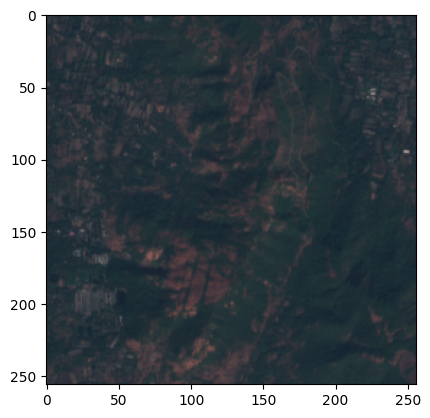

In [32]:
np_iter = ori_train_ds.as_numpy_iterator()
sample_img = np_iter.next()

sample_img = np_iter.next()
plt.imshow(tf.stack([sample_img[0][:,:,3],sample_img[0][:,:,2],sample_img[0][:,:,1]],axis=-1))
plt.show()

# plt.imshow(map_values_to_colors(sample_img[1][:,:,0]))
plt.show()